In [1]:
import os, random, sys, math, joblib, megnet
import json, time, logging
import numpy as np, pandas as pd

from scipy.stats import moment, wasserstein_distance, pearsonr, entropy
from scipy.linalg import eig, inv
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate
from scipy.signal import find_peaks
from scipy.constants import physical_constants, speed_of_light

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap

from pymatgen.core.structure import Structure, Lattice
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.core.periodic_table import Element

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as kb
from tensorflow.keras.layers import Add, Concatenate, Input, Dense, Conv1D, Dropout, Embedding, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from keras.callbacks import Callback, ModelCheckpoint

from megnet.layers import MEGNetLayer, Set2Set
from megnet.models import MEGNetModel, GraphModel
from megnet.data.graph import EmbeddingMap, GaussianDistance
from megnet.data.crystal import CrystalGraph

from ase.io import read, write

import warnings

2024-07-28 19:54:35.422403: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-28 19:54:35.424790: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-28 19:54:35.476031: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-28 19:54:36.647078: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Used this versions of TensorFlow and Keras
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.13.1


In [3]:
warnings.filterwarnings("ignore", message="Issues encountered while parsing CIF")

#### Read data

In [4]:
# Conversion factor from eV to reciprocal cm
eV_to_recip_cm = 1.0 / (physical_constants["Planck constant in eV s"][0] * speed_of_light * 1e2)
factor = 2.0 * np.sqrt(2.0) * np.pi * eV_to_recip_cm

# Read the mbj dataset from a JSON file
with open('../datasets/mbj_avg_data.json', 'r') as f:
    data = json.load(f)

# Convert the JSON data into a pandas DataFrame
dff = pd.DataFrame(data)

# Add a new column 'fidelity' to the DataFrame with a default list value [1]
dff['fidelity'] = [[1] for _ in range(len(dff))]

# Function to convert CIF format to pymatgen Structure objects
def cif2pystructure(row):
    py_struc = Structure.from_str(row['cif'], fmt='cif')
    py_struc.state = row['fidelity']
    return py_struc

# Apply the function to convert CIF to pymatgen structures
dff['pystructure'] = dff.apply(cif2pystructure, axis=1)

# Function to filter DataFrame by number density
def filter_by_number_density(df):
    # Calculate number density for each structure
    df['number_density'] = [df['pystructure'].iloc[i].num_sites / df['pystructure'].iloc[i].volume
                            for i in range(df.shape[0])]
    # Filter rows with number density greater than or equal to 0.005
    df_filtered = df[df['number_density'] >= 0.005]
    # Reset the index numbering
    df_filtered.index = list(np.arange(0, df_filtered.shape[0]))
    return df_filtered

# Apply the number density filter function
dff = filter_by_number_density(dff)

# Function to find the index of the closest value in energy_range to the band_gap
def find_closest_index(row):
    return np.abs(np.array(row['energy_range']) - np.array(row['band_gap'])).argmin()

# Apply the function to find the closest index for each row
dff['band_gap_index'] = dff.apply(find_closest_index, axis=1)

# Function to set values to zero based on band_gap_index
def set_values_to_zero(row):
    band_gap_index = row['band_gap_index']
    imag_avg_interp = row['imag_avg_interp']
    row['imag_avg_interp'] = np.where(np.arange(len(imag_avg_interp)) <= band_gap_index, 0, imag_avg_interp)
    return row

# Apply the function to set values to zero in the imag_avg_interp column
dff = dff.apply(set_values_to_zero, axis=1)

# Calculate absorption coefficient and add it as a new column 'abs_interp'
dff['abs_interp'] = dff.apply(lambda row: (-np.array(row['real_avg_interp']) + 
                                           np.sqrt(np.array(row['real_avg_interp'])**2 + 
                                                   np.array(row['imag_avg_interp'])**2)) * 
                                           np.array(row['energy_range']) * factor, axis=1)

# Reapply the function to find the closest index for each row (redundant, but kept for clarity)
dff['band_gap_index'] = dff.apply(find_closest_index, axis=1)

# Function to set absorption values to zero based on band_gap_index
def set_values_to_zero_abs(row):
    band_gap_index = row['band_gap_index']
    abs_interp = row['abs_interp']
    row['abs_interp'] = np.where(np.arange(len(abs_interp)) <= band_gap_index, 0, abs_interp)
    return row

# Apply the function to set values to zero in the abs_interp column
dff = dff.apply(set_values_to_zero_abs, axis=1)

# Specify a list of columns to include in the sub-DataFrame
selected_columns = ['file', 'pystructure', 'band_gap', 'band_gap_index', 'energy_range', 
                    'imag_avg_interp', 'abs_interp']

# Create the sub-DataFrame from the main DataFrame
df = dff[selected_columns]

# Count non-None values in each column and print the count
non_none_count = df.count()
print('count:', non_none_count)


/home/common/akram/miniconda3_py311/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:142: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


count: file               14560
pystructure        14560
band_gap           14560
band_gap_index     14560
energy_range       14560
imag_avg_interp    14560
abs_interp         14560
dtype: int64


#### Define target and GNN model

In [5]:
# Define the target property ('imag_avg' or 'abs_avg')
# Let's go with 'imag_avg'  
target_prop = 'imag_avg'  

# Model path (This the best performing fidelity-embedding AvgNorm GNN model for predicting the imaginary dielectric function)
model_path = '../GNN_models/FE_imag_AvgNorm_model.hd5'

In [6]:
# Function to split DataFrame into train, validation, and test sets
def train_validate_test_split(df, train_percent=0.80, validate_percent=0.05, seed=42):
    np.random.seed(seed)  # Set the seed for reproducibility
    perm = np.random.permutation(df.index)  # Generate a random permutation of the indices
    m = len(df.index)  # Total number of samples
    train_end = int(train_percent * m)  # Calculate the end index for the training set
    validate_end = int(validate_percent * m) + train_end  # Calculate the end index for the validation set
    df_train = df.iloc[perm[:train_end]]  # Select training set samples
    df_val = df.iloc[perm[train_end:validate_end]]  # Select validation set samples
    df_test = df.iloc[perm[validate_end:]]  # Select test set samples
    return df_train, df_val, df_test  # Return the split dataframes

# Apply the split function to create train, validation, and test sets
df_train, df_val, df_test = train_validate_test_split(df)

# Adjust index numbering for train, validation, and test sets
df_train.index = list(np.arange(0, df_train.shape[0]))
df_val.index = list(np.arange(0, df_val.shape[0]))
df_test.index = list(np.arange(0, df_test.shape[0]))

# Extract structures and target properties for training set
structures_train = df_train['pystructure'].tolist()  # Convert structures to list
targets_train = np.array(df_train[f'{target_prop}_interp'].tolist())  # Convert target properties to numpy array

# Extract structures and target properties for validation set
structures_val = df_val['pystructure'].tolist()  # Convert structures to list
targets_val = np.array(df_val[f'{target_prop}_interp'].tolist())  # Convert target properties to numpy array

# Extract structures and target properties for test set
structures_test = df_test['pystructure'].tolist()  # Convert structures to list
targets_test = np.array(df_test[f'{target_prop}_interp'].tolist())  # Convert target properties to numpy array

#### Read saved model

In [7]:
# Custom loss function
def custom_loss_wrapper(energy_grid_size, energy_grid_delta, loss_weights):
    def custom_loss(y_true, y_pred):
        y1_pred = y_pred[:, :, :1]
        y2_pred = y_pred[:, :, 1:]
        y1_true = y_true[:, :, :1]
        y2_true = y_true[:, :, 1:]
        component1 = kb.mean(kb.abs((y1_pred - y1_true)), axis=-1)
        component2 = 1000 * kb.mean(kb.abs(y2_pred - y2_true), axis=-1)
        loss_components = [component1, component2]
        total_loss = sum(loss_components[i] * loss_weights[i] for i in range(len(loss_components)))
        return total_loss
    return custom_loss

# Metric functions
def metric_1_wrapper(energy_grid_size, energy_grid_delta, loss_weights):
    def component_1(y_true, y_pred):
        y1_pred = y_pred[:, :, :1]
        y2_pred = y_pred[:, :, 1:]
        y1_true = y_true[:, :, :1]
        y2_true = y_true[:, :, 1:]
        component1 = kb.mean(kb.abs((y1_pred - y1_true)), axis=-1)
        return component1
    return component_1

def metric_2_wrapper(energy_grid_size, energy_grid_delta, loss_weights):
    def component_2(y_true, y_pred):
        y1_pred = y_pred[:, :, :1]
        y2_pred = y_pred[:, :, 1:]
        y1_true = y_true[:, :, :1]
        y2_true = y_true[:, :, 1:]
        component2 = 1000 * kb.mean(kb.abs(y2_pred - y2_true), axis=-1)
        return component2
    return component_2

In [8]:
# Set the random seed for reproducibility
keras.utils.set_random_seed(59298)

# Load the pre-trained Keras model with custom loss and metric functions
keras_model = keras.models.load_model(model_path, custom_objects={
    "component_1": metric_1_wrapper,  # Custom metric function 1
    "component_2": metric_2_wrapper,  # Custom metric function 2
    "custom_loss": custom_loss_wrapper  # Custom loss function
})

# Define parameters for the graph converter
r_cutoff = 5.5  # Cutoff radius for considering neighbor atoms
gaussian_width = 0.5  # Width of the Gaussian basis functions
nfeat_bond = 180  # Number of bond features

# Function to build a graph converter
def build_graph_converter(r_cutoff, gaussian_width, nfeat_bond):
    # Create Gaussian centers for the bond features
    gaussian_centers = np.linspace(0, r_cutoff + 1, nfeat_bond)
    # Create a CrystalGraph converter with specified cutoff and bond converter
    graph_converter = CrystalGraph(cutoff=r_cutoff, 
                                   bond_converter=GaussianDistance(gaussian_centers, gaussian_width))
    return graph_converter

# Build the graph converter using the defined parameters
graph_converter = build_graph_converter(r_cutoff, gaussian_width, nfeat_bond)

# Create a graph model by combining the Keras model and the graph converter
graph_model = GraphModel(keras_model, graph_converter)

#### Predict

In [9]:
# Get graphs and targets for training, validation, and test sets
# Convert structures to graphs and pair them with corresponding targets
structure_graphs_train, target_graphs_train = graph_model.get_all_graphs_targets(structures_train, targets_train)
structure_graphs_val, target_graphs_val = graph_model.get_all_graphs_targets(structures_val, targets_val)
structure_graphs_test, target_graphs_test = graph_model.get_all_graphs_targets(structures_test, targets_test)

# Predict on test data
# Convert target graphs to numpy array for test set
y_true_all = np.array(target_graphs_test)
print(y_true_all.shape)  # Print the shape of the true targets

# Initialize an empty list to store predictions
y_pred_all = []

# Loop through each graph in the test set and predict using the graph model
for graph in structure_graphs_test:
    inp = graph_model.graph_converter.graph_to_input(graph)  # Convert graph to model input
    y_pred_all.append(np.squeeze(graph_model.predict(inp, use_multiprocessing=True)))  # Predict and store the result

# Convert the list of predictions to a numpy array
y_pred_all = np.array(y_pred_all)

# Adjust predictions based on energy grid size
energy_grid_size = np.array(df[f'{target_prop}_interp'].iloc[0]).shape[0]
y_pred_all_adjusted = np.expand_dims(y_pred_all[:, 0], axis=-1) * y_pred_all[:, 1:] * energy_grid_size
y_pred_all = y_pred_all_adjusted

# Convert predictions and true values to list of numpy arrays
gnn = y_pred_all.tolist()
dft = y_true_all.tolist()
gnn = [np.array(i) for i in gnn]
dft = [np.array(i) for i in dft]

# Create a DataFrame for test analysis
df_test_analysis = pd.DataFrame({'structures': structures_test, 'dft': dft, 'gnn': gnn})
# Calculate the error between GNN predictions and DFT values
df_test_analysis['Error'] = df_test_analysis['gnn'] - df_test_analysis['dft']
# Calculate the mean absolute error for each structure
df_test_analysis['Error'] = np.mean(np.abs(df_test_analysis['Error'].tolist()), axis=1)

(2184, 300)
1/1 [==============================] - 0s 40ms/step


#### Analyze error

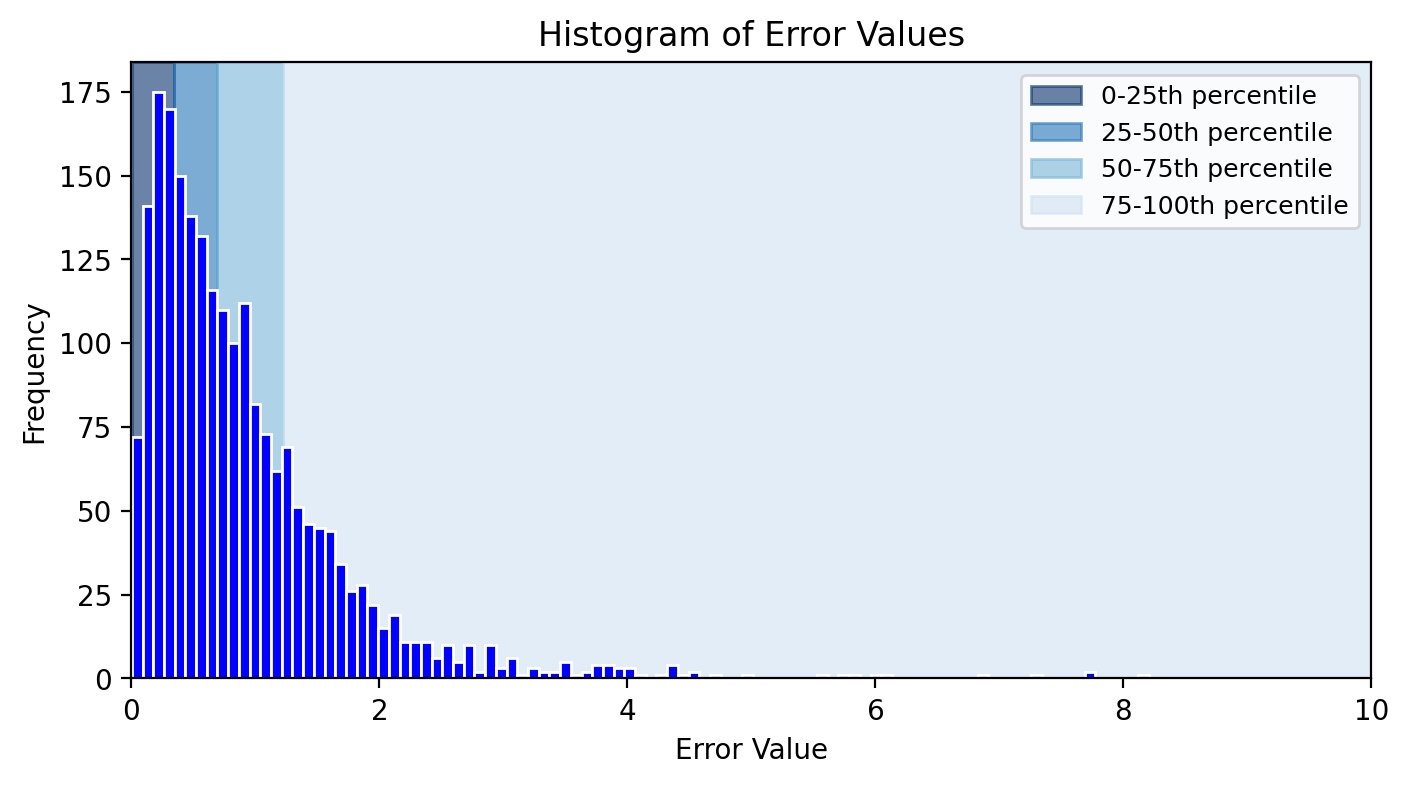

In [10]:
# Plot error histogram
def create_reversed_fading_blue_colormap():
    cmap = plt.cm.Blues
    reversed_cmap = LinearSegmentedColormap.from_list('reversed_fading_blue', cmap(np.linspace(1, 0.2, 256)))
    return reversed_cmap

# Function to plot a histogram of errors with shaded quantile ranges
def plot_error_histogram(errors):
    # Calculate the first, second (median), and third quartiles
    Q1, Q2, Q3 = np.percentile(errors, [25, 50, 75])

    # Create a figure and axes for the histogram
    fig, ax = plt.subplots(figsize=(8, 4), dpi=200)

    # Plot the histogram of errors
    n, bins, patches = plt.hist(errors, bins=1000, color='blue', edgecolor='white', alpha=1.0, zorder=2)

    # Create a reversed fading blue colormap for the shaded regions
    reversed_fading_blue_cmap = create_reversed_fading_blue_colormap()

    # Shade the quantile ranges with the reversed fading blue gradient
    for i in range(4):
        plt.axvspan(np.percentile(errors, i * 25),
                    np.percentile(errors, (i + 1) * 25), alpha=0.6, color=reversed_fading_blue_cmap(i / 3), zorder=1)

    # Set the labels for the x and y axes
    plt.xlabel('Error Value')
    plt.ylabel('Frequency')

    # Set the title of the plot
    plt.title('Histogram of Error Values')

    # Create legend patches for the shaded regions
    legend_patches = [mpatches.Patch(color=reversed_fading_blue_cmap(i / 3), 
                                     alpha=0.6, label=f'{i * 25}-{(i + 1) * 25}th percentile') for i in range(4)]
    plt.legend(handles=legend_patches, loc='best', fontsize=9)

    # Set the x-axis limits
    plt.xlim([0, 10])

    # Show the plot
    plt.show()

# Plot the error histogram for the test analysis errors
plot_error_histogram(df_test_analysis['Error'].tolist())

#### Select samples around the median

In [11]:
# Function to select examples from a specified quantile range of errors
def select_all_examples_from_quantile_range(df, lower_quantile, upper_quantile):
    # Convert the 'Error' column to a list
    errors = df['Error'].tolist()
    # Calculate the lower and upper bounds for the specified quantiles
    lower_bound = np.percentile(errors, lower_quantile)
    upper_bound = np.percentile(errors, upper_quantile)
    # Select samples within the specified quantile range
    selected_samples_df = df[(lower_bound <= df['Error']) & (df['Error'] <= upper_bound)]
    return selected_samples_df

In [13]:
N_plot = 30
lower_quantile=45; upper_quantile=55

# Apply the function to select samples from the 45th to 55th quantile range of errors
df_samples = select_all_examples_from_quantile_range(df_test_analysis, lower_quantile, upper_quantile)
# Reset the index of the selected samples DataFrame
df_samples.index = list(np.arange(0, df_samples.shape[0]))

# Randomly sample 40 examples from the selected samples
df_selected_samples = df_samples.sample(N_plot)
# Reset the index of the selected samples DataFrame after sampling
df_selected_samples.reset_index(drop=True, inplace=True)

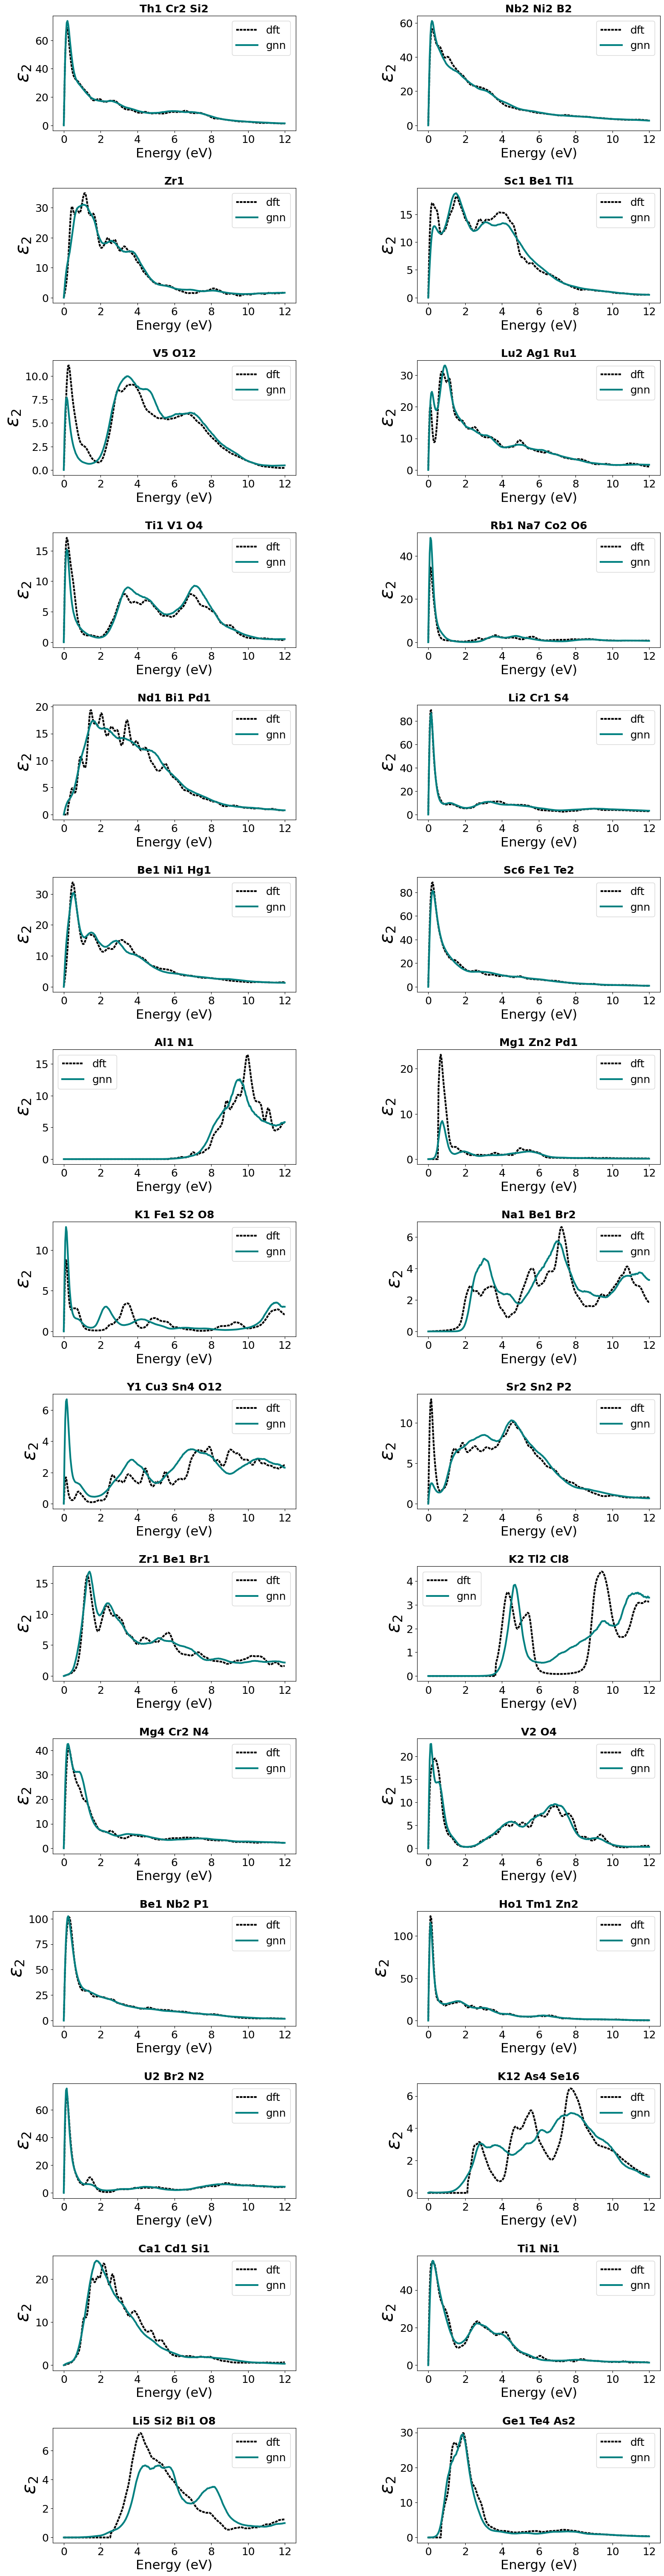

In [14]:
# Function to plot dielectric curves for the selected samples
def plot_dielectric_curves(df):
    num_plots = df.shape[0]  # Get the number of plots needed
    # Create a figure and axes for the plots
    if num_plots == 1:
        fig, ax = plt.subplots(figsize=(15, 6), dpi=200)  # Single plot
        ax = [ax]
    else:
        fig, ax = plt.subplots(int(np.ceil(num_plots/2)), 2, figsize=(15, 2*num_plots), dpi=100)  # Multiple plots
        ax = ax.flatten()
    fig.tight_layout()  # Adjust the layout
    fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust the spacing between subplots

    # Loop through each row in the DataFrame and plot the dielectric curves
    for i, row in df.iterrows():
        structure = row['structures']  # Get the structure
        reference = row['dft']  # Get the reference DFT values
        predicted = row['gnn']  # Get the predicted GNN values

        # Define the resolution and create a new x-axis range for interpolation
        res_ = 0.01
        x_new = np.arange(0, 12, res_)
        
        # Interpolate the reference and predicted curves
        reference_interp = np.interp(x_new, np.arange(0, 12, 0.04), reference)
        predicted_interp = np.interp(x_new, np.arange(0, 12, 0.04), predicted)
        
        # Plot the reference (DFT) and predicted (GNN) curves
        ax[i].plot(x_new, reference_interp, label='dft', c='black', linestyle=(0, (1.5, 0.5)), linewidth=3.0)
        ax[i].plot(x_new, predicted_interp, label='gnn', c='teal', linewidth=3.0)
        
        # Set the title to the chemical formula of the structure
        chemical_formula = structure.composition.formula
        ax[i].set_title(chemical_formula, fontsize=18, fontweight='bold')
        
        # Set the labels for the x and y axes
        ax[i].set_xlabel('Energy (eV)', fontsize=22)
        ax[i].set_ylabel('$\epsilon_2$', fontsize=32)
        
        # Add legend and adjust tick parameters
        ax[i].legend(fontsize=18)
        ax[i].tick_params(axis='both', which='major', labelsize=18)

    # Display the plot
    plt.show()

# Plot the dielectric curves for the selected samples
plot_dielectric_curves(df_selected_samples)